# Heart Disease Prediction
### Written by Patrick Da Silva
* The aim of this project is to apply the basics of Pyspark, Scikit-learn, Pandas, and Matplotlib as well as to experiment with the machine learning pipeline
* This model will assess common influences on heart disease to potentially predict early onset of the disease
* Ideally this project could be used to help patients receive preventative care before the regular onset of symptoms

## Step 1: Import libraries and data

In [ ]:
!pip install matplotlib sklearn

In [17]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

#### Import Pyspark, Start an Enviornment, and Import Data

In [2]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName('Heart Disease Data') \
    .getOrCreate()

In [3]:
heart_data = (spark.read
              .format('csv')
              .option('header', 'true')
              .load('data/heart.csv')
             )

## Step 2: Conduct exploratory data analysis to assess general correlation among variables

In [4]:
#Peeking into the first 5 rows to make sure data 'looks' correct
print(heart_data.show(5))

#Pyspark converted all the data into strings - type cast integers and floats back to the correct values
from pyspark.sql.functions import col
heart_data = heart_data.select(
    col('Age').cast('float'),
    col('Sex'),
    col('ChestPainType'),
    col('RestingBP').cast('float'),
    col('Cholesterol').cast('float'),
    col('FastingBS').cast('float'),
    col('RestingECG'),
    col('MaxHR').cast('float'),
    col('ExerciseAngina'),
    col('Oldpeak').cast('float'),
    col('ST_Slope'),
    col('HeartDisease').cast('int'),
)

#Switch the pyspark dataframe into a pandas dataframe (pyspark has an ML library, but I will not be using it for this project)
heart_data = heart_data.toPandas()

#Descriptive statistics of our data
print('Descriptive stats of Heart Attack data\n', heart_data.describe().transpose(), '\n', sep = '')

#Check for missing values. None are found in this dataset
print('Checking for missing values\n', heart_data.isnull().any(), '\n', sep = '')

#Check the types of data. All that are 'object' will need to be 'One Hot Encoded'
print('Checking data types\n', heart_data.dtypes, sep = '')

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|      0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|      1|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|      0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|      0|      Up|           0|
+---+---+-------------+---------+-----------+---------+-

### Analysis:
##### There are no missing values. <br>
##### Cholesterol has a large standard deviation, so graph to view potential skew. <br>

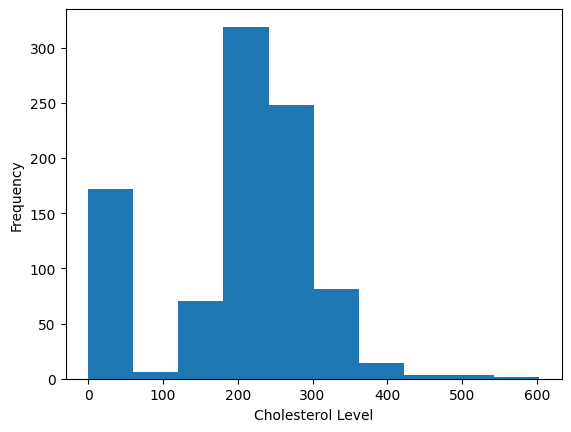

In [20]:
loss_eval = plt.hist(heart_data['Cholesterol'])
plt.xlabel('Cholesterol Level')
plt.ylabel('Frequency')
plt.show()

##### Cholesterol is bimodal and skewed to the right. If imputation were necessary, I may choose to use the mode as the measure of central tendency

### Step 3: Choosing the target feature (the feature I want to predict)

In [21]:
#chosing the column 'HeartDisease' {0: absence of heart disease, 1: has heart disease}
target = heart_data.pop('HeartDisease')

#Print out proportion of people in the dataset that have heart disease to see if dataset is biased
print(sum(target)/len(target))

0.5533769063180828


### Step 4: Selecting Features and Normalizing

In [22]:
#One Hot Encoding for categorical variables
heart_data_ohe = pd.get_dummies(heart_data)

#need to apply special conversion to Oldpeak, since it has negative values
op_min = heart_data_ohe.Oldpeak.min()
heart_data_ohe.Oldpeak = heart_data_ohe.Oldpeak.map(lambda x: abs(x) - op_min)

#normalize all columns
predictors = list(heart_data_ohe.columns)
heart_data_ohe[predictors] = heart_data_ohe[predictors]/heart_data_ohe[predictors].max()

In [23]:
#Check head to verify computations were successful (should have min >= 0 and max <= 1)
heart_data_ohe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,918.0,0.694947,0.122502,0.363636,0.610390,0.701299,0.779221,1.0
RestingBP,918.0,0.661983,0.092571,0.000000,0.600000,0.650000,0.700000,1.0
Cholesterol,918.0,0.329684,0.181400,0.000000,0.287313,0.369818,0.442786,1.0
FastingBS,918.0,0.233115,0.423046,0.000000,0.000000,0.000000,0.000000,1.0
MaxHR,918.0,0.677274,0.126041,0.297030,0.594059,0.683168,0.772277,1.0
Oldpeak,918.0,0.399460,0.118490,0.295455,0.295455,0.363636,0.465909,1.0
Sex_F,918.0,0.210240,0.407701,0.000000,0.000000,0.000000,0.000000,1.0
Sex_M,918.0,0.789760,0.407701,0.000000,1.000000,1.000000,1.000000,1.0
ChestPainType_ASY,918.0,0.540305,0.498645,0.000000,0.000000,1.000000,1.000000,1.0
ChestPainType_ATA,918.0,0.188453,0.391287,0.000000,0.000000,0.000000,0.000000,1.0


### Step 5: Split data into training and validation sets

In [25]:
train_X, val_X, train_Y, val_Y = train_test_split(heart_data_ohe, target, random_state = 0)

### Step 6: Specify and fit the model

In [26]:
heart_data_ohe_model = RandomForestRegressor(random_state = 0)
heart_data_ohe_model.fit(train_X, train_Y)

RandomForestRegressor(random_state=0)

### Step 7: Making predictions and assessing error

In [27]:
heart_data_predictions = heart_data_ohe_model.predict(val_X)
mae = mean_absolute_error(val_Y, heart_data_predictions)
print('Mean Absolute Error is', mae)

Mean Absolute Error is 0.21756521739130438


## Conclusions:
#### Model Analysis:
- This model was able to predict heart disease status with 79% accuracy

#### Limitations:
- There were roughly 900 rows of data, which could be augmented for better results
- I did not calculate a confusion matrix, so I there is uncertainty with how the model is currently performing

#### Future Directions:
- Implementing cross validation to give a more accurate measure of model performance
- Integrate this model into an existing patient database to automatically update clinicians on patients who may be at risk for heart disease